# Sentinel 2 Classifiers

## Scikitlearn supervised classification for exploring Greenland's Dark Zone

### Written by Joseph Cook, University of Sheffield (UK), June 2018

##### This code uses supervised classification algorithms, trained on reflectance data from field spectroscopy, to identify various ice surfaces in satellite images of the Greenland Ice Sheet's Dark Zone. Specifically, this script is designed to identify algal blooms on the ice surface, and the labels used to classify the surface are: Heavy Algae, Light Algae, Clean Ice, Snow, Water and Cryoconite. After classifying the surface the multispectral Sentinel-2 data is converted into an albedo value for each pixel using a narrowband-broadband conversion from Liang et al. (2002). The requisite datasets, along with this code as a python script, are provided at github.com/jmcook1186/IceSurfClassifers/.
##### This notebook includes functions for reading in directional reflectance data obtained via ground spectroscopy, reformatting into a pandas dataframe of features and labels, optimising and training a series of machine learning algorithms on the ground spectra then using the trained model to predict the surface type in each pixel of a Sentinel-2 image. The Sentinel-2 image has been preprocessed using ESA Sen2Cor command line algorithm to convert to surface reflectance before being saved as a multiband TIF which is then loaded here. Three individual sub-areas within the main image are selected for analysis, maximising the glaciated area included in the study.
##### The raw hyperspectral data is first organised into separate pandas dataframes for each surface class. The data is then reduced down to the reflectance values at the eight key wavelengths and the remaining data discarded. The dataset is then arranged into columns with one column per wavelength and a separate column for the surface class. The dataset's features are the reflectance at each wavelength, and the labels are the surface types. The dataframes for each surface type are merged into one large dataframe and then the labels are removed and saved as a separate dataframe. The dataframe XX contains all the data features, dataframe YY contains the labels only. No scaling of the data is required because the reflectance is already normalised between 0 and 1 by the spectrometer.
##### Each classifier (Naive Bayes, K-NN, SVM, Voting Classifier, Random Forest) is trained and the performance on the training set is reported. The user can define which performance measure is most important, and the best performing classifier according to the chosen metric is automatically selected as the final model. That model is then evaluated on the test set and used to classify each pixel in the UAV image. The classified image is displayed and the spatial statistics calculated.
##### NB The classifier can also be loaded in from a joblib save file - in this case omit the call to the optimise_train_model() function and simply load the trained classifier into the workspace with the variable name 'clf'. Run the other functions as normal.
##### The trained classifier can also be exported to a joblib savefile by running the save_classifier() function,enabling the trained model to be replicated in other scripts. To precisely replicate figures from our paper it will be necessary to load our trained model in this manner, so the file is provided in the github repository.
##### The albedo of each classified pixel is then calculated from the reflectance at each individual wavelength using the narrowband-broadband conversion of Liang et al (2002), creating a final dataframe containing broadband albedo and surface type. The spatial statistics of the albedo dataset is reported in the final script.
##### Improvements, updates and extensions to this code are welcome, please contact Joseph Cook (joe.cook@sheffield.ac.uk) to discuss collaboration opportunities.


#### Import Modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing, cross_validation, neighbors, svm
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.externals import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import gdal
import rasterio
from sklearn.grid_search import GridSearchCV
from datetime import datetime

%matplotlib inline
plt.style.use('ggplot')

/home/joe/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/joe/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


##### Download TRAINING DATA AND SENTINEL-2 IMAGES
##### Download the training data and Sentinel-2 image files from github.com/jmcook1186/IceSurfClassifiers to your working
##### directory, then update wdir in the cell below to match your working directory
##### This notebook offers Sentinel2 imagery for the same region of Greenland's Dark Zone on 21st July 2016 or 2017 

In [2]:

wdir = '/home/joe/Code/IceSurfClassifiers/'
year = 2016


##### Preprocess and format training data

,R140,R210,R315,R355,R390,R433,R515,R1260,R1840,label
0,0.265322,0.261297,0.264513,0.269127,0.212500,0.188158,0.135064,0.016714,0.015250,HA
1,0.190086,0.183343,0.183677,0.191492,0.172613,0.147951,0.117169,0.011255,0.010749,HA
2,0.249323,0.244835,0.265702,0.285143,0.277992,0.256976,0.224172,0.007047,0.007108,HA
3,0.212544,0.206466,0.217183,0.236710,0.244927,0.231803,0.216290,0.022853,0.022192,HA
4,0.154518,0.155388,0.195648,0.234990,0.269367,0.294573,0.300215,0.007025,0.007401,HA


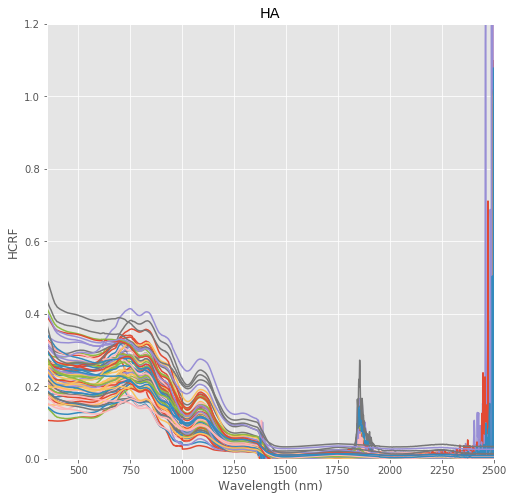

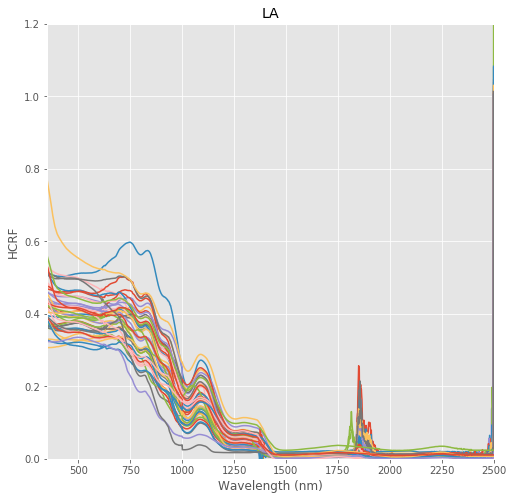

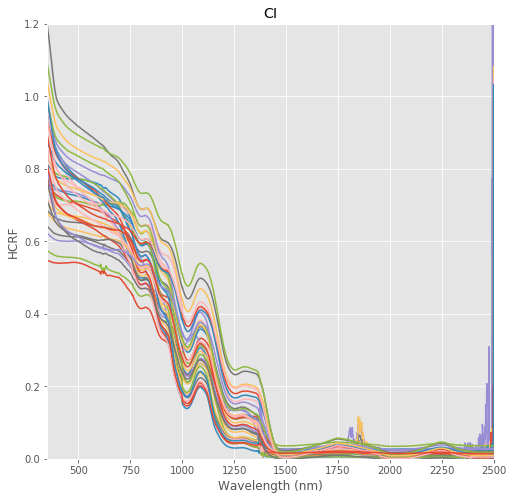

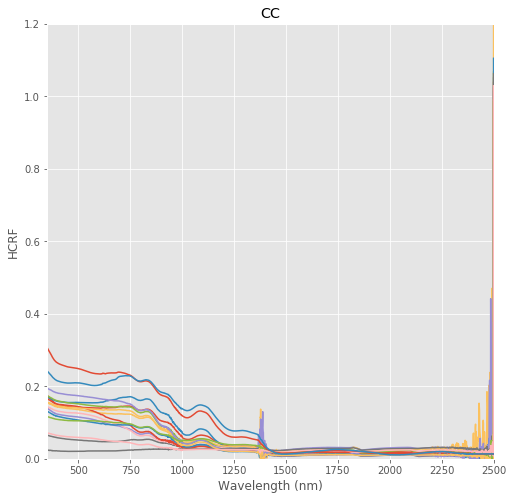

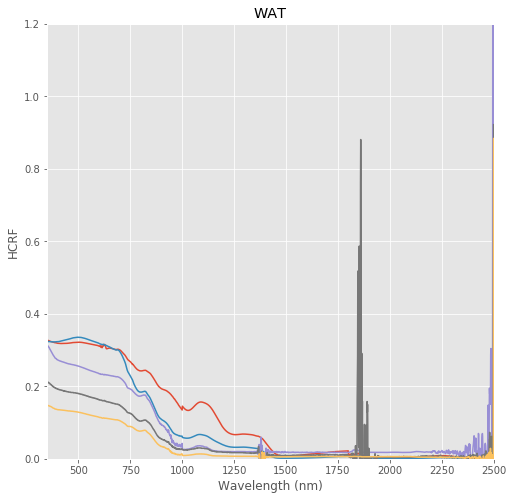

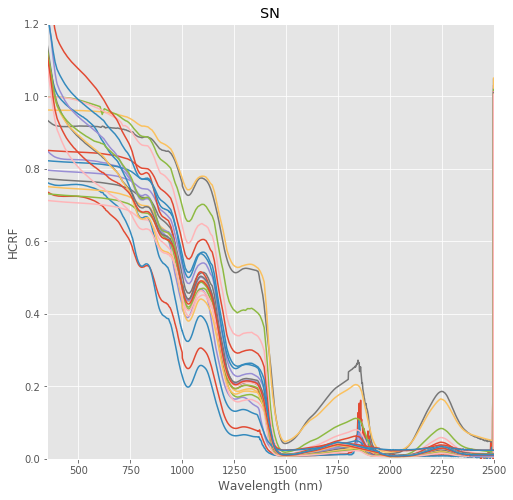

In [3]:
def create_dataset(year,plot_spectra=True):

    HCRF_file = str(wdir+'Training_Data/HCRF_master_machine_snicar.csv')

    if year == 2016:
        Sentinel_jp2s = [str(wdir+'2016_Sentinel/B02_20m.jp2'),
        str(wdir+'2016_Sentinel/B03_20m.jp2'),
        str(wdir+'2016_Sentinel/B04_20m.jp2'),
        str(wdir+'2016_Sentinel/B05_20m.jp2'),
        str(wdir+'2016_Sentinel/B06_20m.jp2'),
        str(wdir+'2016_Sentinel/B07_20m.jp2'),
        str(wdir+'2016_Sentinel/B8A_20m.jp2'),
        str(wdir+'2016_Sentinel/B11_20m.jp2'),
        str(wdir+'2016_Sentinel/B12_20m.jp2')]
    
    elif year == 2017:    
        Sentinel_jp2s = [str(wdir+'2017_Sentinel/B02_20m.jp2'),
        str(wdir+'2017_Sentinel/B03_20m.jp2'),
        str(wdir+'2017_Sentinel/B04_20m.jp2'),
        str(wdir+'2017_Sentinel/B05_20m.jp2'),
        str(wdir+'2017_Sentinel/B06_20m.jp2'),
        str(wdir+'2017_Sentinel/B07_20m.jp2'),
        str(wdir+'2017_Sentinel/B8A_20m.jp2'),
        str(wdir+'2017_Sentinel/B11_20m.jp2'),
        str(wdir+'2017_Sentinel/B12_20m.jp2')]
    
    else:
        print('ERROR: Only 2016 and 2017 images are provided in this notebook,please amend *year* variable')
            
    
    # Read in raw HCRF data to DataFrame. This version pulls in HCRF data from 2016 and 2017
    hcrf_master = pd.read_csv(HCRF_file)
    HA_hcrf = pd.DataFrame()
    LA_hcrf = pd.DataFrame()
    CI_hcrf = pd.DataFrame()
    CC_hcrf = pd.DataFrame()
    WAT_hcrf = pd.DataFrame()
    SN_hcrf = pd.DataFrame()
    
    # Group filenames from master csv by surface class (HA = heavy algal bloom, LA = light algal bloom,
    # CI = clean ice, SN= snow, WAT = water, CC = cryoconite)
    
    HAsites = ['13_7_SB2','13_7_SB4','14_7_S5','14_7_SB1','14_7_SB5','14_7_SB10',
    '15_7_SB3','21_7_SB1','21_7_SB7','22_7_SB4','22_7_SB5','22_7_S3','22_7_S5',
    '23_7_SB3','23_7_SB5','23_7_S3','23_7_SB4','24_7_SB2','HA_1', 'HA_2','HA_3',
    'HA_4','HA_5','HA_6','HA_7','HA_8','HA_10','HA_11','HA_12','HA_13','HA_14',
    'HA_15','HA_16','HA_17','HA_18','HA_19','HA_20','HA_21','HA_22','HA_24',
    'HA_25','HA_26','HA_27','HA_28','HA_29','HA_30','HA_31','13_7_S2','14_7_SB9',
    'MA_11','MA_14','MA_15','MA_17','21_7_SB2','22_7_SB1','MA_4','MA_7','MA_18',
    '27_7_16_SITE3_WMELON1', '27_7_16_SITE3_WMELON3','27_7_16_SITE2_ALG1',
    '27_7_16_SITE2_ALG2', '27_7_16_SITE2_ALG3', '27_7_16_SITE2_ICE3','27_7_16_SITE2_ICE5',
    '27_7_16_SITE3_ALG4','5_8_16_site2_ice7','5_8_16_site3_ice2', '5_8_16_site3_ice3',
    '5_8_16_site3_ice5', '5_8_16_site3_ice6', '5_8_16_site3_ice7',
    '5_8_16_site3_ice8', '5_8_16_site3_ice9']
    
    LAsites = ['14_7_S2','14_7_S3','14_7_SB2','14_7_SB3','14_7_SB7','15_7_S2','15_7_SB4',
    '20_7_SB1','20_7_SB3','21_7_S1','21_7_S5','21_7_SB4','22_7_SB2','22_7_SB3','22_7_S1',
    '23_7_S1','23_7_S2','24_7_S2','MA_1','MA_2','MA_3','MA_5','MA_6','MA_8','MA_9',
    'MA_10','MA_12','MA_13','MA_16','MA_19','13_7_S1','13_7_S3','14_7_S1','15_7_S1',
    '15_7_SB2','20_7_SB2','21_7_SB5','21_7_SB8','25_7_S3','5_8_16_site2_ice10','5_8_16_site2_ice5',
    '5_8_16_site2_ice9','27_7_16_SITE3_WHITE3']
    
    CIsites =['21_7_S4','13_7_SB3','15_7_S4','15_7_SB1','15_7_SB5','21_7_S2',
    '21_7_SB3','22_7_S2','22_7_S4','23_7_SB1','23_7_SB2','23_7_S4',
    'WI_1','WI_2','WI_4','WI_5','WI_6','WI_7','WI_9','WI_10','WI_11',
    'WI_12','WI_13','27_7_16_SITE3_WHITE1', '27_7_16_SITE3_WHITE2', 
    '27_7_16_SITE2_ICE2','27_7_16_SITE2_ICE4','27_7_16_SITE2_ICE6',
    '5_8_16_site2_ice1',  '5_8_16_site2_ice2', '5_8_16_site2_ice3', '5_8_16_site2_ice4',
    '5_8_16_site2_ice6','5_8_16_site2_ice8','5_8_16_site3_ice1','5_8_16_site3_ice4']
    
    CCsites = ['DISP1','DISP2','DISP3','DISP4','DISP5','DISP6','DISP7','DISP8','DISP9','DISP10',
    'DISP11','DISP12','DISP13','DISP14','27_7_16_SITE3_DISP1', '27_7_16_SITE3_DISP3',]
    
    WATsites = ['21_7_SB5','21_7_SB8','WAT_1','WAT_3','WAT_6','21_7_SB5','21_7_SB8','WAT_1','WAT_3','WAT_6',
    '21_7_SB5','21_7_SB8','WAT_1','WAT_3','WAT_6','21_7_SB5','21_7_SB8','WAT_1','WAT_3','WAT_6',
    '21_7_SB5','21_7_SB8','WAT_1','WAT_3','WAT_6','21_7_SB5','21_7_SB8','WAT_1','WAT_3','WAT_6']
    
    SNsites = ['14_7_S4','14_7_SB6','14_7_SB8','17_7_SB2','SNICAR100','SNICAR200',
    'SNICAR300','SNICAR400','SNICAR500','SNICAR600','SNICAR700','SNICAR800','SNICAR900','SNICAR1000',
    '14_7_S4','14_7_SB6','14_7_SB8','17_7_SB2','SNICAR100','SNICAR200',
    'SNICAR300','SNICAR400','SNICAR500','SNICAR600','SNICAR700','SNICAR800','SNICAR900','SNICAR1000',
    '14_7_S4','14_7_SB6','14_7_SB8','17_7_SB2','SNICAR100','SNICAR200',
    'SNICAR300','SNICAR400','SNICAR500','SNICAR600','SNICAR700','SNICAR800','SNICAR900','SNICAR1000',
    '27_7_16_KANU_','27_7_16_SITE2_1','5_8_16_site1_snow10', '5_8_16_site1_snow2', '5_8_16_site1_snow3',
    '27_7_16_KANU_','27_7_16_SITE2_1','5_8_16_site1_snow10', '5_8_16_site1_snow2', '5_8_16_site1_snow3',
    '5_8_16_site1_snow4', '5_8_16_site1_snow6','5_8_16_site1_snow7', '5_8_16_site1_snow9',
    '5_8_16_site1_snow4', '5_8_16_site1_snow6','5_8_16_site1_snow7', '5_8_16_site1_snow9',
    '5_8_16_site1_snow4', '5_8_16_site1_snow6','5_8_16_site1_snow7', '5_8_16_site1_snow9',
    '5_8_16_site1_snow4', '5_8_16_site1_snow6','5_8_16_site1_snow7', '5_8_16_site1_snow9',
    '5_8_16_site1_snow4', '5_8_16_site1_snow6','5_8_16_site1_snow7', '5_8_16_site1_snow9']
    
    
    # Create dataframes for classification algorithm. organise each dataframe into columns for features and labels,
    # then concatenate into a single dataframe
    
    for i in HAsites:
        hcrf_HA = np.array(hcrf_master[i])
        HA_hcrf['{}'.format(i)] = hcrf_HA
    
    for ii in LAsites:
        hcrf_LA = np.array(hcrf_master[ii])
        LA_hcrf['{}'.format(ii)] = hcrf_LA
         
    for iii in CIsites:   
        hcrf_CI = np.array(hcrf_master[iii])
        CI_hcrf['{}'.format(iii)] = hcrf_CI   
    
    for iv in CCsites:   
        hcrf_CC = np.array(hcrf_master[iv])
        CC_hcrf['{}'.format(iv)] = hcrf_CC   
    
    for v in WATsites:   
        hcrf_WAT = np.array(hcrf_master[v])
        WAT_hcrf['{}'.format(v)] = hcrf_WAT  

    for vi in SNsites:
        hcrf_SN = np.array(hcrf_master[vi])
        SN_hcrf['{}'.format(vi)] = hcrf_SN 
    
    
    # Plot the training data with each surface class in a separate plot (only if plot_spectra is set to True in function call)
    
    if plot_spectra:

        WL = np.arange(350,2501,1)
        
        HA_hcrf.plot(figsize=(8,8),x = WL,legend=None),plt.ylim(0,1.2),plt.title('HA'),
        plt.xlabel('Wavelength (nm)'),plt.ylabel('HCRF')
        
        LA_hcrf.plot(figsize=(8,8),x = WL,legend=None),plt.ylim(0,1.2),plt.title('LA'),
        plt.xlabel('Wavelength (nm)'),plt.ylabel('HCRF')
        
        CI_hcrf.plot(figsize=(8,8),x = WL,legend=None),plt.ylim(0,1.2),plt.title('CI'),
        plt.xlabel('Wavelength (nm)'),plt.ylabel('HCRF')
        
        CC_hcrf.plot(figsize=(8,8),x = WL,legend=None),plt.ylim(0,1.2),plt.title('CC'),
        plt.xlabel('Wavelength (nm)'),plt.ylabel('HCRF')
        
        WAT_hcrf.plot(figsize=(8,8),x = WL,legend=None),plt.ylim(0,1.2),plt.title('WAT'),
        plt.xlabel('Wavelength (nm)'),plt.ylabel('HCRF')
        
        SN_hcrf.plot(figsize=(8,8),x = WL,legend=None),plt.ylim(0,1.2),plt.title('SN'),
        plt.xlabel('Wavelength (nm)'),plt.ylabel('HCRF')
   
    # Make dataframe with column for label, columns for reflectancxe at key wavelengths
    # select wavelengths to use - currently set to 8 Sentnel 2 bands
    
    X = pd.DataFrame()

    X['R140'] = np.array(HA_hcrf.iloc[140])
    X['R210'] = np.array(HA_hcrf.iloc[210])
    X['R315'] = np.array(HA_hcrf.iloc[315])
    X['R355'] = np.array(HA_hcrf.iloc[355])
    X['R390'] = np.array(HA_hcrf.iloc[390])
    X['R433'] = np.array(HA_hcrf.iloc[433])
    X['R515'] = np.array(HA_hcrf.iloc[515])
    X['R1260'] = np.array(HA_hcrf.iloc[1260])
    X['R1840'] = np.array(HA_hcrf.iloc[1840])
    
    X['label'] = 'HA'
    
    
    Y = pd.DataFrame()
    Y['R140'] = np.array(LA_hcrf.iloc[140])
    Y['R210'] = np.array(LA_hcrf.iloc[210])
    Y['R315'] = np.array(LA_hcrf.iloc[315])
    Y['R355'] = np.array(LA_hcrf.iloc[355])
    Y['R390'] = np.array(LA_hcrf.iloc[390])
    Y['R433'] = np.array(LA_hcrf.iloc[433])
    Y['R515'] = np.array(LA_hcrf.iloc[515])
    Y['R1260'] = np.array(LA_hcrf.iloc[1260])
    Y['R1840'] = np.array(LA_hcrf.iloc[1840])
    
    Y['label'] = 'LA'
    
    
    Z = pd.DataFrame()
    
    Z['R140'] = np.array(CI_hcrf.iloc[140])
    Z['R210'] = np.array(CI_hcrf.iloc[210])
    Z['R315'] = np.array(CI_hcrf.iloc[315])
    Z['R355'] = np.array(CI_hcrf.iloc[355])
    Z['R390'] = np.array(CI_hcrf.iloc[390])
    Z['R433'] = np.array(CI_hcrf.iloc[433])
    Z['R515'] = np.array(CI_hcrf.iloc[515])
    Z['R1260'] = np.array(CI_hcrf.iloc[1260])
    Z['R1840'] = np.array(CI_hcrf.iloc[1840])
    
    Z['label'] = 'CI'
    
    
    P = pd.DataFrame()
    
    P['R140'] = np.array(CC_hcrf.iloc[140])
    P['R210'] = np.array(CC_hcrf.iloc[210])
    P['R315'] = np.array(CC_hcrf.iloc[315])
    P['R355'] = np.array(CC_hcrf.iloc[355])
    P['R390'] = np.array(CC_hcrf.iloc[390])
    P['R433'] = np.array(CC_hcrf.iloc[433])
    P['R515'] = np.array(CC_hcrf.iloc[515])
    P['R1260'] = np.array(CC_hcrf.iloc[1260])
    P['R1840'] = np.array(CC_hcrf.iloc[1840])
    
    P['label'] = 'CC'
    
    
    Q = pd.DataFrame()
    Q['R140'] = np.array(WAT_hcrf.iloc[140])
    Q['R210'] = np.array(WAT_hcrf.iloc[210])
    Q['R315'] = np.array(WAT_hcrf.iloc[315])
    Q['R355'] = np.array(WAT_hcrf.iloc[355])
    Q['R390'] = np.array(WAT_hcrf.iloc[390])
    Q['R433'] = np.array(WAT_hcrf.iloc[433])
    Q['R515'] = np.array(WAT_hcrf.iloc[515])
    Q['R1260'] = np.array(WAT_hcrf.iloc[1260])
    Q['R1840'] = np.array(WAT_hcrf.iloc[1840])
    
    Q['label'] = 'WAT'
    
    R = pd.DataFrame()
    R['R140'] = np.array(SN_hcrf.iloc[140])
    R['R210'] = np.array(SN_hcrf.iloc[210])
    R['R315'] = np.array(SN_hcrf.iloc[315])
    R['R355'] = np.array(SN_hcrf.iloc[355])
    R['R390'] = np.array(SN_hcrf.iloc[390])
    R['R433'] = np.array(SN_hcrf.iloc[433])
    R['R515'] = np.array(SN_hcrf.iloc[515])
    R['R1260'] = np.array(SN_hcrf.iloc[1260])
    R['R1840'] = np.array(SN_hcrf.iloc[1840])
    
    R['label'] = 'SN'
    
    X = X.append(Y,ignore_index=True)
    X = X.append(Z,ignore_index=True)
    X = X.append(P,ignore_index=True)
    X = X.append(Q,ignore_index=True)
    X = X.append(R,ignore_index=True)

    
    # Create features and labels (XX = features - all data but no labels, YY = labels only)
    XX = X.drop(['label'],1)
    YY = X['label']
    
    
    return Sentinel_jp2s,X, XX, YY


#Call function
Sentinel_jp2s,X,XX,YY = create_dataset(year=2016,plot_spectra=True)
X.head() #print the top 5 rows of the dataframe

##### Train a range of supervised classification algorithms, determine the best performing and evaluate it on the test set

/home/joe/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/joe/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best parameters set found on development set:
{'C': 1000, 'gamma': 0.1, 'kernel': 'linear'}



/home/joe/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/joe/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



*** MODEL TEST SUMMARY ***
KNN accuracy =  0.875912408759 KNN_F1_Score =  0.861905877148 KNN Recall =  0.875912408759 KNN precision =  0.85205273939
Naive Bayes accuracy =  0.802919708029 Naive_Bayes_F1_Score =  0.795103210109 Naive Bayes Recall =  0.802919708029 Naive Bayes Precision =  0.793530476012
SVM accuracy =  0.92700729927 SVM_F1_Score =  0.924973523405 SVM recall =  0.92700729927 SVM Precision =  0.926903339969
Random Forest accuracy 0.985401459854 Random Forest F1 Score =  0.985696379857 Random Forest Recall 0.985401459854 Random Forest Precision =  0.987165450122
Ensemble accuracy 0.912408759124 Ensemble F1 Score =  0.898234674316 Ensemble Recall 0.912408759124 Ensemble Precision =  0.889757383991

RF model chosen

Feature Importances
(relative importance of each feature (wavelength) for prediction)

R140 0.120681286095
R210 0.136775570783
R315 0.144939311116
R355 0.127794083969
R390 0.102918931834
R433 0.135584100245
R515 0.144692144518
R1260 0.0449855720489
R1840 0.04162

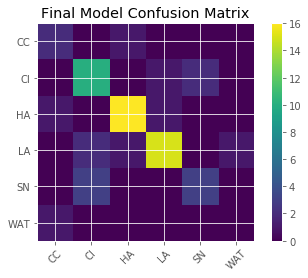

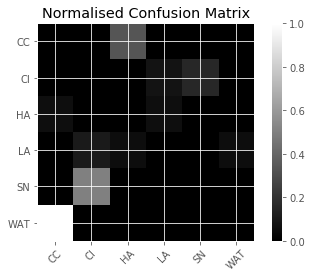

In [4]:
def optimise_train_model(X,XX,YY, error_selector, test_size = 0.3, plot_all_conf_mx = True):
    
    # Function splits the data into training and test sets, then tests the 
    # performance of a range of models on the training data. The final model 
    # selected is then evaluated using the test set. The function automatically
    # selects the model that performs best on the training sets. All 
    # performance metrics are printed to ipython. The performance metric 
    # to use to select the model is determined in the function call. Options 
    # for error_selector are: 'accuracy', 'F1', 'recall', 'precision', and 
    # 'average_all_metric' 
    # The option 'plot_all_conf_mx' can be se to True or False. If True, the 
    # train set confusion matrices will be plotted for all models. If False,
    # only the final model confusion matrix will be plotted.
    # X, XX, YY are the datasets with and without labels.

    # split data into test and train sets.
    X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(XX,YY,test_size = test_size)
    
    # test different classifers and report performance metrics using traning data only
    
    # 1. Try Naive Bayes
    clf_NB = GaussianNB()
    clf_NB.fit(X_train,Y_train)
    accuracy_NB = clf_NB.score(X_train,Y_train) #calculate accuracy
    Y_predict_NB = clf_NB.predict(X_train) # make nre prediction
    conf_mx_NB = confusion_matrix(Y_train,Y_predict_NB) # calculate confusion matrix
    recall_NB = recall_score(Y_train,Y_predict_NB,average="weighted")
    f1_NB = f1_score(Y_train, Y_predict_NB, average="weighted") # calculate f1 score
    precision_NB = precision_score(Y_train,Y_predict_NB, average = 'weighted')
    average_metric_NB = (accuracy_NB+recall_NB+f1_NB)/3
    
    # 2. Try K-nearest neighbours
    clf_KNN = neighbors.KNeighborsClassifier()
    clf_KNN.fit(X_train,Y_train)
    accuracy_KNN = clf_KNN.score(X_train,Y_train)
    Y_predict_KNN = clf_KNN.predict(X_train)
    conf_mx_KNN = confusion_matrix(Y_train,Y_predict_KNN)
    recall_KNN = recall_score(Y_train,Y_predict_KNN,average="weighted")
    f1_KNN = f1_score(Y_train, Y_predict_KNN, average="weighted")
    precision_KNN = precision_score(Y_train,Y_predict_KNN, average = 'weighted')
    average_metric_KNN = (accuracy_KNN + recall_KNN + f1_KNN)/3
    
    # 3. Try support Vector Machine with best params calculated using
    # GridSearch cross validation optimisation
    tuned_parameters = [
        {'kernel': ['linear'], 'gamma': [1e-1, 1e-2, 1e-3, 1e-4],
                     'C': [0.1, 1, 10, 100, 1000, 10000]},
                    {'kernel': ['rbf'], 'gamma': [1e-1, 1e-2, 1e-3, 1e-4],
                     'C': [0.1, 1, 10, 100, 1000, 10000]},
                    {'kernel':['poly'], 'gamma': [1e-1, 1e-2, 1e-3, 1e-4],
                     'C':[0.1,1,10,100,1000,10000]},
                    {'kernel':['sigmoid'],'gamma': [1e-1, 1e-2, 1e-3, 1e-4],
                     'C':[0.1,1,10,100,1000,10000]}
                    ]
    
    clf_svm = GridSearchCV(svm.SVC(C=1), tuned_parameters, cv=3)
    clf_svm.fit(X_train, Y_train)
    
    print()
    print("Best parameters set found on development set:")
    print(clf_svm.best_params_)
    print() #line break
    
    kernel = clf_svm.best_estimator_.get_params()['kernel']
    C = clf_svm.best_estimator_.get_params()['C']
    gamma = clf_svm.best_estimator_.get_params()['gamma']
    
    clf_svm = svm.SVC(kernel=kernel, C=C, gamma = gamma,probability=True)
    clf_svm.fit(X_train,Y_train)
    accuracy_svm = clf_svm.score(X_train,Y_train)
    Y_predict_svm = clf_svm.predict(X_train)
    conf_mx_svm = confusion_matrix(Y_train,Y_predict_svm)
    recall_svm = recall_score(Y_train,Y_predict_svm,average="weighted")
    f1_svm = f1_score(Y_train, Y_predict_svm, average="weighted")
    precision_svm = precision_score(Y_train,Y_predict_svm, average = 'weighted')
    average_metric_svm = (accuracy_svm + recall_svm + f1_svm)/3

    # 4. Try  a random forest classifier
    clf_RF = RandomForestClassifier(n_estimators = 1000, max_leaf_nodes = 16,n_jobs=-1)
    clf_RF.fit(X_train,Y_train)
    accuracy_RF = clf_RF.score(X_train,Y_train)
    Y_predict_RF = clf_RF.predict(X_train)
    conf_mx_RF = confusion_matrix(Y_train,Y_predict_RF)
    recall_RF = recall_score(Y_train,Y_predict_RF,average="weighted")
    f1_RF = f1_score(Y_train, Y_predict_RF, average="weighted")
    precision_RF = precision_score(Y_train,Y_predict_RF, average = 'weighted')
    average_metric_RF = (accuracy_RF + recall_RF + f1_RF)/3

    # 5. Try an ensemble of all the other classifiers (not RF) using the voting classifier method
    ensemble_clf = VotingClassifier(
            estimators = [('NB',clf_NB),('KNN',clf_KNN),('svm',clf_svm),('RF',clf_RF)],
            voting = 'hard')
    ensemble_clf.fit(X_train,Y_train)
    accuracy_ensemble = ensemble_clf.score(X_train,Y_train)
    Y_predict_ensemble = ensemble_clf.predict(X_train)
    conf_mx_ensemble = confusion_matrix(Y_train,Y_predict_ensemble)
    recall_ensemble = recall_score(Y_train,Y_predict_ensemble,average="weighted")
    f1_ensemble = f1_score(Y_train, Y_predict_ensemble, average="weighted")
    precision_ensemble = precision_score(Y_train,Y_predict_ensemble, average = 'weighted')
    average_metric_ensemble = (accuracy_ensemble + recall_ensemble + f1_ensemble)/3
    
    print()
    print('*** MODEL TEST SUMMARY ***')
    print('KNN accuracy = ',accuracy_KNN, 'KNN_F1_Score = ', f1_KNN, 'KNN Recall = ', recall_KNN, 'KNN precision = ', precision_KNN)
    print('Naive Bayes accuracy = ', accuracy_NB, 'Naive_Bayes_F1_Score = ',f1_NB, 'Naive Bayes Recall = ',recall_NB, 'Naive Bayes Precision = ', precision_NB)
    print('SVM accuracy = ',accuracy_svm, 'SVM_F1_Score = ', f1_svm, 'SVM recall = ', recall_svm, 'SVM Precision = ', precision_svm)
    print('Random Forest accuracy',accuracy_RF,'Random Forest F1 Score = ', f1_RF, 'Random Forest Recall', recall_RF, 'Random Forest Precision = ', precision_RF)    
    print('Ensemble accuracy',accuracy_ensemble,'Ensemble F1 Score = ', f1_ensemble, 'Ensemble Recall', recall_ensemble, 'Ensemble Precision = ', precision_ensemble)
    
    # PLOT CONFUSION MATRICES
    if plot_all_conf_mx:
        
        plt.figure()    
        plt.imshow(conf_mx_NB)
        plt.title('NB Model Confusion matrix')
        plt.colorbar()
        classes = clf_NB.classes_
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        
        plt.figure()
        plt.imshow(conf_mx_KNN)
        plt.title('KNN Model Confusion matrix')
        plt.colorbar()
        classes = clf_KNN.classes_
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        
        plt.figure()
        plt.imshow(conf_mx_svm)
        plt.title('SVM Model Confusion matrix')
        plt.colorbar()
        classes = clf_svm.classes_
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        plt.figure()
        plt.imshow(conf_mx_RF)
        plt.title('Random Forest Model Confusion matrix')
        plt.colorbar()
        classes = clf_RF.classes_
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        plt.figure()
        plt.imshow(conf_mx_ensemble)
        plt.title('Ensemble Model Confusion Matrix')
        plt.colorbar()
        classes = ensemble_clf.classes_
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        
    print() #line break
    
    if error_selector == 'accuracy':
        
        if accuracy_KNN > accuracy_svm and accuracy_KNN > accuracy_NB and accuracy_KNN > accuracy_RF and accuracy_KNN > accuracy_ensemble:
            clf = neighbours.KNeighboursClassifier()
            clf.fit(X_train,Y_train)
            print('KNN model chosen')
        
        elif accuracy_NB > accuracy_KNN and accuracy_NB > accuracy_svm and accuracy_NB > accuracy_RF and accuracy_NB > accuracy_ensemble:
            clf = clf_NB
            clf.fit(X_train,Y_train)
            print('Naive Bayes model chosen')
            
        elif accuracy_svm > accuracy_NB and accuracy_svm > accuracy_KNN and accuracy_KNN > accuracy_RF and accuracy_svm > accuracy_ensemble:
            clf = clf_svm
            clf.fit(X_train,Y_train)
            print('SVM model chosen')
            print('SVM Params: C = ', C, ' gamma = ', gamma, ' kernel = ', kernel)

        elif accuracy_RF > accuracy_NB and accuracy_RF > accuracy_KNN and accuracy_RF > accuracy_ensemble and accuracy_RF> accuracy_svm:
            clf = clf_RF
            clf.fit(X_train,Y_train)
            print('RF model chosen')
            
        elif accuracy_ensemble > accuracy_svm and accuracy_ensemble > accuracy_NB and accuracy_ensemble > accuracy_RF and accuracy_ensemble > accuracy_KNN:
            clf = clf_ensemble
            clf.fit(X_train,Y_train)
            print('Ensemble model chosen')


    elif error_selector == 'recall':


        if recall_KNN > recall_svm and recall_KNN > recall_NB and recall_KNN > recall_RF and recall_KNN > recall_ensemble:
            clf = neighbours.KNeighboursClassifier()
            clf.fit(X_train,Y_train)
            print('KNN model chosen')
        
        elif recall_NB > recall_KNN and recall_NB > recall_svm and recall_NB > recall_RF and recall_NB > recall_ensemble:
            clf = GaussianNB()
            clf.fit(X_train,Y_train)
            print('Naive Bayes model chosen')
            
        elif recall_svm > recall_NB and recall_svm > recall_KNN and recall_svm > recall_RF and recall_svm > recall_ensemble:
            clf = svm.SVC(kernel=kernel, C=C, gamma = gamma, probability=True)
            clf.fit(X_train,Y_train)
            print('SVM model chosen')
            print('SVM Params: C = ', C, ' gamma = ', gamma, ' kernel = ', kernel)
        
        elif recall_RF > recall_NB and recall_RF > recall_KNN and recall_RF > recall_ensemble and recall_RF> recall_svm:
            clf = clf_RF
            clf.fit(X_train,Y_train)
            print('RF model chosen')


        elif recall_ensemble > recall_svm and recall_ensemble > recall_NB and recall_NB > recall_RF and recall_ensemble > recall_KNN:
            clf = VotingClassifier(
                    estimators = [('NB',clf_NB),('SVM',clf_svm),('KNN',clf_KNN)], voting = 'hard')
            clf.fit(X_train,Y_train)
            print('Ensemble model chosen')

        
    elif error_selector == 'F1':
        
        if f1_KNN > f1_svm and f1_KNN > f1_NB and f1_KNN > f1_RF and f1_KNN > f1_ensemble:
            clf = neighbours.KNeighboursClassifier()
            clf.fit(X_train,Y_train)
            print('KNN model chosen')
        
        elif f1_NB > f1_KNN and f1_NB > f1_svm and f1_NB > f1_RF and f1_NB > f1_ensemble:
            clf = GaussianNB()
            clf.fit(X_train,Y_train)
            print('Naive Bayes model chosen')
            
        elif f1_svm > f1_NB and f1_svm > f1_KNN and f1_svm > f1_RF and f1_svm > f1_ensemble:
            clf = svm.SVC(kernel=kernel, C=C, gamma = gamma, probability = True)
            clf.fit(X_train,Y_train)
            print('SVM model chosen')
            print('SVM Params: C = ', C, ' gamma = ', gamma, ' kernel = ', kernel)
            
        elif f1_RF > f1_NB and f1_RF > f1_KNN and f1_RF > f1_ensemble and f1_RF> f1_svm:
            clf = clf_RF
            clf.fit(X_train,Y_train)
            print('RF model chosen')
        
        elif f1_ensemble > f1_svm and f1_ensemble > f1_NB and f1_ensemble > f1_RF and f1_ensemble > f1_KNN:
            clf = VotingClassifier(
                    estimators = [('NB',clf_NB),('SVM',clf_svm),('KNN',clf_KNN)], voting = 'hard')
            clf.fit(X_train,Y_train)
            print('Ensemble model chosen')
            

    elif error_selector == 'precision':
        
        if precision_KNN > precision_svm and precision_KNN > precision_NB and precision_KNN > precision_RF and precision_KNN > precision_ensemble:
            clf = neighbours.KNeighboursClassifier()
            clf.fit(X_train,Y_train)
            print('KNN model chosen')
        
        elif precision_NB > precision_KNN and precision_NB > precision_svm and precision_NB > precision_RF and precision_NB > precision_ensemble:
            clf = GaussianNB()
            clf.fit(X_train,Y_train)
            print('Naive Bayes model chosen')
            
        elif precision_RF > precision_NB and precision_RF > precision_KNN and precision_RF > precision_ensemble and precision_RF> precision_svm:
            clf = clf_RF
            clf.fit(X_train,Y_train)
            print('RF model chosen')
            
        elif precision_svm > precision_NB and precision_svm > precision_KNN and precision_svm > precision_RF and precision_svm > precision_ensemble:
            clf = svm.SVC(kernel=kernel, C=C, gamma = gamma, probability=True)
            clf.fit(X_train,Y_train)
            print('SVM model chosen')
            print('SVM Params: C = ', C, ' gamma = ', gamma, ' kernel = ', kernel)
        
        elif precision_ensemble > precision_svm and precision_ensemble > precision_NB and precision_ensemble > precision_RF and precision_ensemble > precision_KNN:
            clf = VotingClassifier(
                    estimators = [('NB',clf_NB),('SVM',clf_svm),('KNN',clf_KNN)], voting = 'hard')
            clf.fit(X_train,Y_train)
            print('Ensemble model chosen')

    elif error_selector == 'average_all_metric':
        
        if average_metric_KNN > average_metric_svm and average_metric_KNN > average_metric_NB and average_metric_KNN > average_metric_RF and average_metric_KNN > average_metric_ensemble:
            clf = neighbours.KNeighboursClassifier()
            clf.fit(X_train,Y_train)
            print('KNN model chosen')
        
        elif average_metric_NB > average_metric_KNN and average_metric_NB > average_metric_svm and average_metric_NB > average_metric_RF and average_metric_NB > average_metric_ensemble:
            clf = GaussianNB()
            clf.fit(X_train,Y_train)
            print('Naive Bayes model chosen')
            
        elif average_metric_RF > average_metric_NB and average_metric_RF > average_metric_KNN and average_metric_RF > average_metric_ensemble and average_metric_RF> average_metric_svm:
            clf = clf_RF
            clf.fit(X_train,Y_train)
            print('RF model chosen')
            
        elif average_metric_svm > average_metric_NB and average_metric_svm > average_metric_KNN and average_metric_svm > average_metric_RF and average_metric_svm > average_metric_ensemble:
            clf = svm.SVC(kernel=kernel, C=C, gamma = gamma, probability=True)
            clf.fit(X_train,Y_train)
            print('SVM model chosen')
            print('SVM Params: C = ', C, ' gamma = ', gamma, ' kernel = ', kernel)
        
        elif average_metric_ensemble > average_metric_svm and average_metric_ensemble > average_metric_NB and average_metric_ensemble > average_metric_RF and average_metric_ensemble > average_metric_KNN:
            clf = VotingClassifier(
                    estimators = [('NB',clf_NB),('SVM',clf_svm),('KNN',clf_KNN)], voting = 'hard')
            clf.fit(X_train,Y_train)
            print('Ensemble model chosen')
            
# Now that model has been selected using error metrics from training data, the final
# model can be evaluated on the test set. The code below therefore measures the f1, recall,
# confusion matrix and accuracy  for the final selected model and prints to ipython.
            
    Y_test_predicted = clf.predict(X_test)
    final_conf_mx = confusion_matrix(Y_test, Y_test_predicted)

    plt.figure()
    plt.imshow(final_conf_mx)
    plt.title('Final Model Confusion Matrix')
    plt.colorbar()
    classes = clf.classes_
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Normalise confusion matrix to show errors
    row_sums = final_conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = final_conf_mx / row_sums
    np.fill_diagonal(norm_conf_mx, 0)
    plt.figure()
    plt.imshow(norm_conf_mx, cmap=plt.cm.gray)
    plt.colorbar()
    plt.clim(0,1)
    plt.title('Normalised Confusion Matrix')
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    final_recall = recall_score(Y_test,Y_test_predicted,average="weighted")
    final_f1 = f1_score(Y_test, Y_test_predicted, average="weighted")
    final_accuracy = clf.score(X_test,Y_test)
    final_precision = precision_score(Y_test, Y_test_predicted, average='weighted')
    final_average_metric = (final_recall + final_accuracy + final_f1)/3

    # The Feature importances 
    print()
    print('Feature Importances')
    print('(relative importance of each feature (wavelength) for prediction)')
    print()
    for name, score in zip(X.columns,clf.feature_importances_):
        print (name,score)

    print() #line break
    print ('*** FINAL MODEL SUMMARY ***')
    print('Final Model Accuracy = ', final_accuracy)
    print('Final Model Recall = ', final_recall)
    print('Final Model F1 = ', final_f1)
    print('Final Model Precision = ',final_precision)
    print('Final Model Average metric = ', final_average_metric)


    return clf


#Call function
# NB UndefinedMetricWarning is informing user that the performance estimates are only meaningful if several
# instances from each surface class are available in both the training and test sets. Rerun the cell until this condition
# is satisifed (no warning shown)

clf =  optimise_train_model(X,XX,YY, error_selector = 'precision', test_size = 0.3, plot_all_conf_mx = False)


##### Save the model to file so that it can be re-used

In [5]:
def save_classifier(clf):
    
    # pickle the classifier model for archiving or for reusing in another code
    joblibfile = 'Sentinel2_classifier.pkl'
    joblib.dump(clf,joblibfile)
    
    # to load this classifier into another code use the following syntax:
    #clf = joblib.load(joblib_file)
    
    return None

# Call function
#save_classifier(clf)

##### Classify images using the trained algorithm


Time taken to classify image =  0:21:24.732808
Below are classified images of each of three ablation zone areas along with albedo maps for the same areas


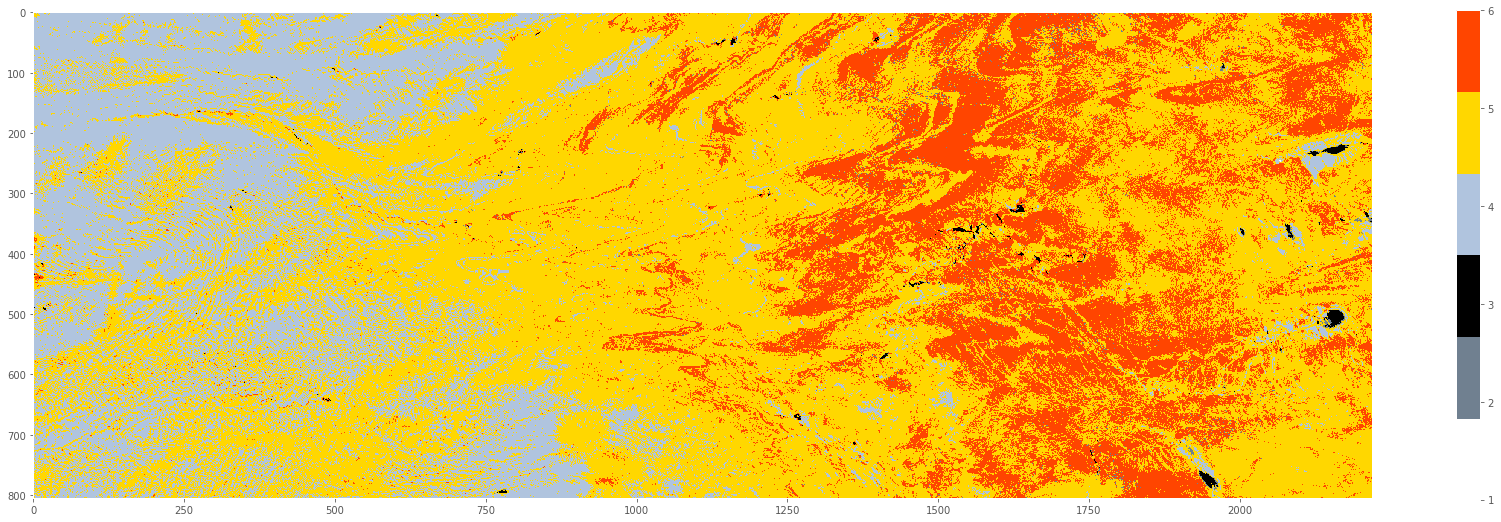

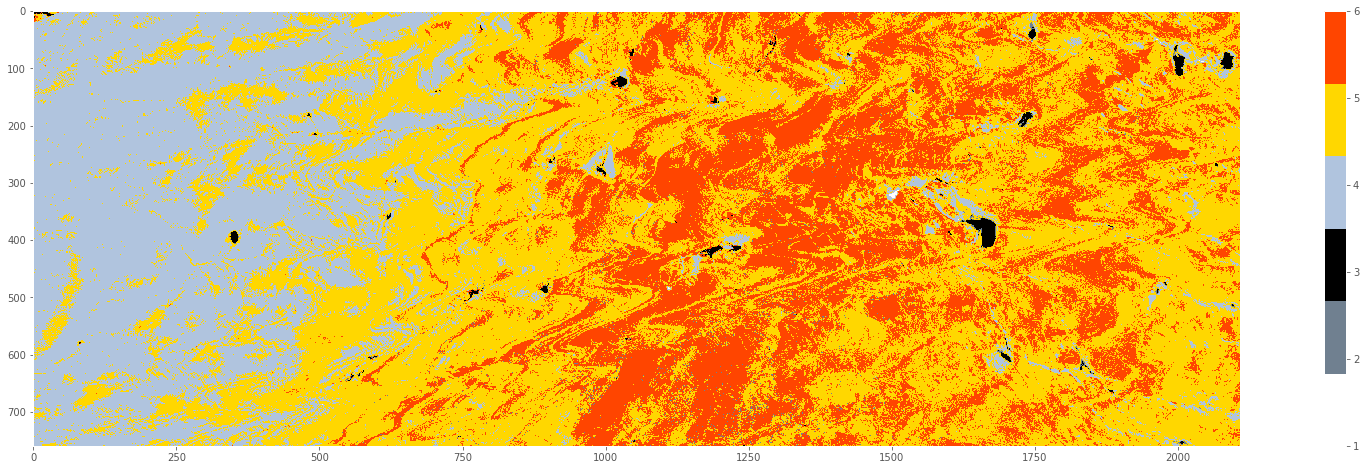

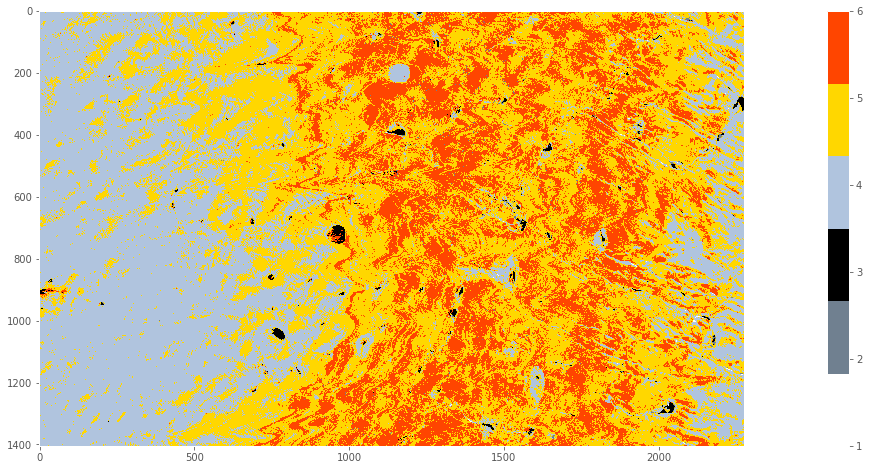

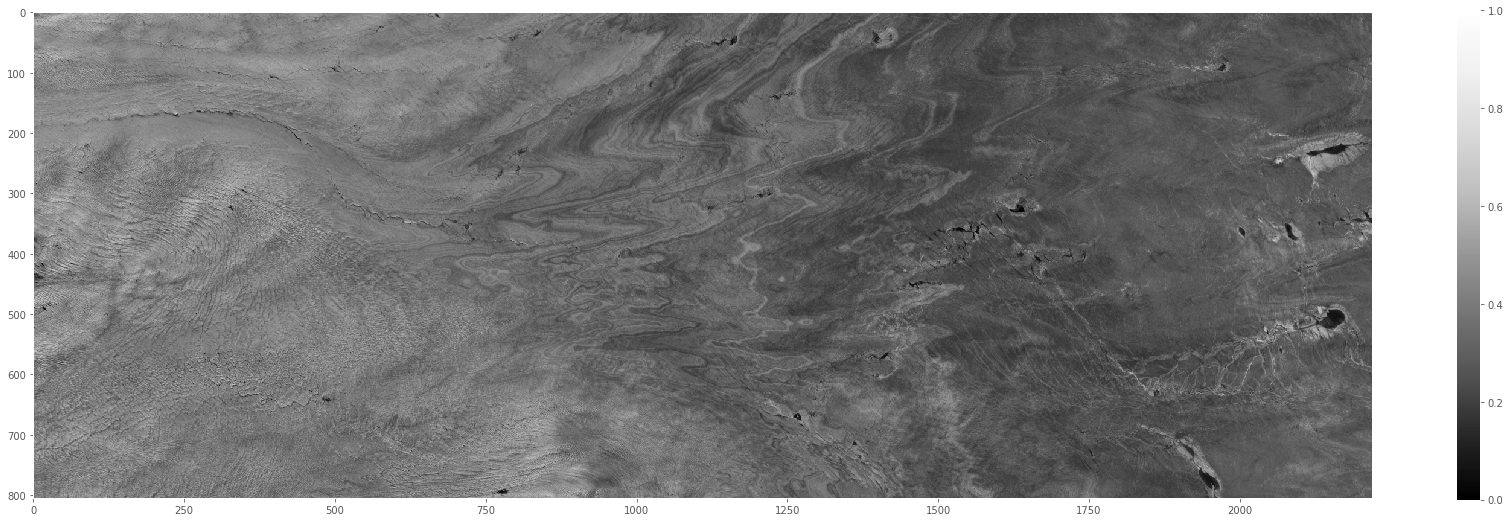

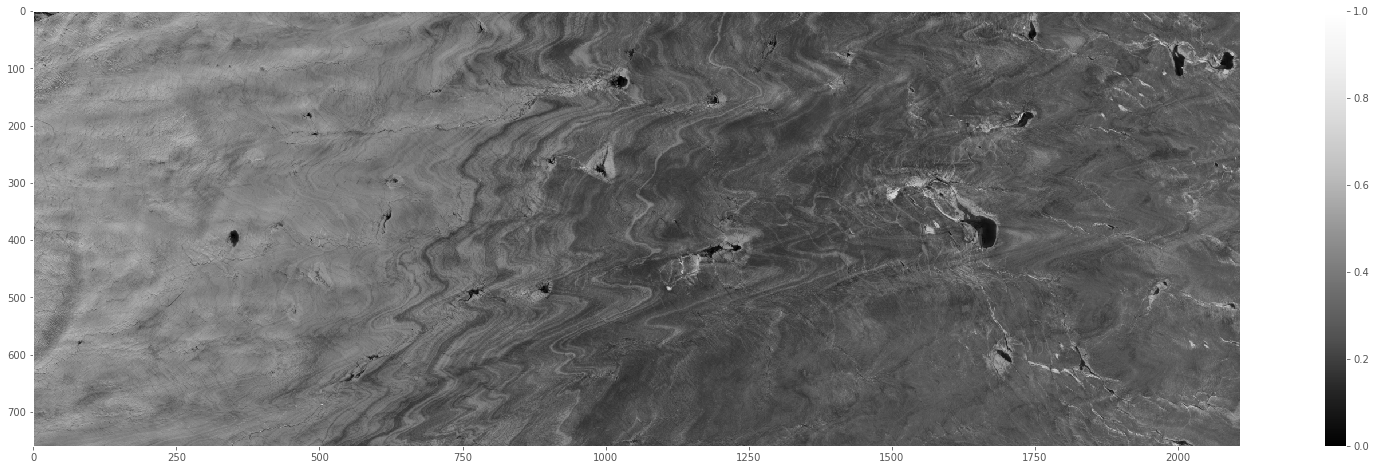

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [6]:
def ClassifyImages(Sentinel_jp2s,clf):
    startTime = datetime.now()
    
    # Import multispectral imagery from Sentinel 2 and apply ML algorithm to classify surface
    
    arrs = []   
    for jp2 in Sentinel_jp2s:
        with rasterio.open(jp2) as f:
            arrs.append(f.read(1))
    
    data = np.array(arrs, dtype=arrs[0].dtype)
    
    predicted = []
    test_array = []
    albedo_array = []
    
    # get dimensions of each band layer
    lenx, leny = np.shape(data[0])
    
    #convert image bands into single 5-dimensional numpy array
    test_array = np.array([data[0]/10000, data[1]/10000,data[2]/10000,data[3]/10000,data[4]/10000,
                          data[5]/10000,data[6]/10000,data[7]/10000,data[8]/10000])       
    test_array = test_array.reshape(9,lenx*leny) #reshape into 5 x 1D arrays
    test_array = test_array.transpose() # transpose sot hat bands are read as features
    # create albedo array by applying Knap (1999) narrowband - broadband conversion
    albedo_array = np.array([0.356*(data[0]/10000)+0.13*(data[2]/10000)+0.373*(data[6]/10000)+0.085*(data[7]/10000)+0.072*(data[8]/10000)-0.0018])

    #apply classifier to each pixel in multispectral image with bands as features   
    predicted = clf.predict(test_array)

    # apply ML algorithm to 4-value array for each pixel - predict surface type    
    predicted = clf.predict(test_array)
    
    # convert surface class (string) to a numeric value for plotting
    predicted[predicted == 'SN'] = float(1)
    predicted[predicted == 'WAT'] = float(2)
    predicted[predicted == 'CC'] = float(3)
    predicted[predicted == 'CI'] = float(4)
    predicted[predicted == 'LA'] = float(5)
    predicted[predicted == 'HA'] = float(6)
    
    # ensure array data type is float (required for imshow)
    predicted = predicted.astype(float)
    
    # reshape 1D array back into original image dimensions
    predicted = np.reshape(predicted,[lenx,leny])
    albedo_array = np.reshape(albedo_array,[lenx,leny])

    #split image into 3 ice-covered areas that together represent majority of glaciated land in image  
          
    predicted1 = predicted[2170:2975,2130:4350]
    predicted2 = predicted[1400:2160,2630:4740]
    predicted3 = predicted[0:1405,2800:5075]
    albedo_array1 = albedo_array[2170:2975,2130:4350] 
    albedo_array2 = albedo_array[1400:2160,2630:4740]
    albedo_array3 = albedo_array[0:1405,2800:5075]

    cmap1 = mpl.colors.ListedColormap(['white','slategray','black','lightsteelblue','gold','orangered'])
    cmap2 = 'Greys_r'
    
    #plot classified surface
    
    plt.figure(figsize = (30,9)),plt.imshow(predicted1,cmap=cmap1),plt.colorbar(cmap=cmap1),plt.grid(None)
    plt.figure(figsize = (30,8)),plt.imshow(predicted2,cmap=cmap1),plt.colorbar(cmap=cmap1),plt.grid(None)
    plt.figure(figsize = (30,8)),plt.imshow(predicted3,cmap=cmap1),plt.colorbar(cmap=cmap1),plt.grid(None)
    plt.figure(figsize = (30,9)),plt.imshow(albedo_array1,cmap=cmap2,vmin=0,vmax=1),plt.colorbar(cmap=cmap2),plt.grid(None)
    plt.figure(figsize = (30,8)),plt.imshow(albedo_array2,cmap=cmap2,vmin=0,vmax=1),plt.colorbar(cmap=cmap2),plt.grid(None)
    plt.figure(figsize = (30,8)),plt.imshow(albedo_array3,cmap=cmap2,vmin=0,vmax=1),plt.colorbar(cmap=cmap2),plt.grid(None)
    print()
    print('Time taken to classify image = ',datetime.now() - startTime)
    print('Below are classified images of each of three ablation zone areas along with albedo maps for the same areas')

    return predicted1, predicted2, predicted3,albedo_array1,albedo_array2,albedo_array3

# Call Function
# WARNING: This section takes ~20 minutes to run (w/ 32GB RAM, i7-7700Ghz processor)

predicted1,predicted2,predicted3,albedo_array1,albedo_array2,albedo_array3 =  ClassifyImages(Sentinel_jp2s,clf)

##### analyse the classified image and report the coverage statistics

In [7]:
def CoverageStats(predicted1, predicted2, predicted3):
    res = 0.02 # Ground resolution of sentinel data in km
    counter = 0
    
    for i in predicted1,predicted2,predicted3:
        
        counter +=1

        x,y = np.shape(i)
        area_of_image = (x*res)*(y*res) # area of selected region

        # Calculate coverage stats
        numHA = (i==6).sum()
        numLA = (i==5).sum()
        numCI = (i==4).sum()
        numCC = (i==3).sum()
        numWAT = (i==2).sum()
        numSN = (i==1).sum()
        total_pix = numHA+numLA+numCI+numCC+numWAT+numSN
        
        tot_alg_coverage = (numHA+numLA)/total_pix*100
        HA_coverage = (numHA)/total_pix * 100
        LA_coverage = (numLA)/total_pix * 100
        CI_coverage = (numCI)/total_pix * 100
        CC_coverage = (numCC)/total_pix * 100
        WAT_coverage = (numWAT)/total_pix * 100
        SN_coverage = (numSN)/total_pix * 100
        
        # Print coverage summary
        print()
        print('**** SUMMARY ****')
        print('{} Area of image = '.format(counter), area_of_image, 'km')
        print('{}  % algal coverage (Hbio + Lbio) = '.format(counter),np.round(tot_alg_coverage,2))
        print('{}  % Hbio coverage = '.format(counter),np.round(HA_coverage,2))
        print('{}  % Lbio coverage = '.format(counter),np.round(LA_coverage,2))
        print('{}  % cryoconite coverage = '.format(counter),np.round(CC_coverage,2))
        print('{}  % clean ice coverage = '.format(counter),np.round(CI_coverage,2))
        print('{}  % water coverage = '.format(counter),np.round(WAT_coverage,2))
        print('{}  % snow coverage = '.format(counter),np.round(SN_coverage,2))
        print()
        print()
        
    return

# Call function
CoverageStats(predicted1,predicted2,predicted3)


**** SUMMARY ****
1 Area of image =  714.84 km
1  % algal coverage (Hbio + Lbio) =  77.02
1  % Hbio coverage =  18.98
1  % Lbio coverage =  58.04
1  % cryoconite coverage =  0.18
1  % clean ice coverage =  22.4
1  % water coverage =  0.4
1  % snow coverage =  0.0



**** SUMMARY ****
2 Area of image =  641.44 km
2  % algal coverage (Hbio + Lbio) =  74.8
2  % Hbio coverage =  25.04
2  % Lbio coverage =  49.76
2  % cryoconite coverage =  0.34
2  % clean ice coverage =  24.4
2  % water coverage =  0.46
2  % snow coverage =  0.01



**** SUMMARY ****
3 Area of image =  1278.55 km
3  % algal coverage (Hbio + Lbio) =  66.77
3  % Hbio coverage =  21.31
3  % Lbio coverage =  45.46
3  % cryoconite coverage =  0.4
3  % clean ice coverage =  32.56
3  % water coverage =  0.25
3  % snow coverage =  0.02




##### Report the albedo statistics for each of the three sub-areas within the image

In [8]:
def albedo_report_by_site(predicted1,predicted2,predicted3,albedo_array1,albedo_array2,albedo_array3):
        
    counter = 0
    
    albedo_DF1 = pd.DataFrame()
    albedo_DF2 = pd.DataFrame()
    albedo_DF3 = pd.DataFrame()
    HA_DF1 = pd.DataFrame()
    LA_DF1 = pd.DataFrame()
    WAT_DF1 = pd.DataFrame()
    CI_DF1 = pd.DataFrame()
    CC_DF1 = pd.DataFrame()
    SN_DF1 = pd.DataFrame()
    HA_DF2 = pd.DataFrame()
    LA_DF2 = pd.DataFrame()
    WAT_DF2 = pd.DataFrame()
    CI_DF2 = pd.DataFrame()
    CC_DF2 = pd.DataFrame()
    SN_DF2 = pd.DataFrame()
    HA_DF3 = pd.DataFrame()
    LA_DF3 = pd.DataFrame()
    WAT_DF3 = pd.DataFrame()
    CI_DF3 = pd.DataFrame()
    CC_DF3 = pd.DataFrame()
    SN_DF3 = pd.DataFrame()
    
    for i in predicted1,predicted2,predicted3:
        
        counter +=1
        
        PP = i.ravel()
        print(len(PP))
        
        if counter == 1:
           
            AA = albedo_array1.ravel()
            albedo_DF1['class'] = PP
            albedo_DF1['albedo'] = AA
             
    # divide albedo dataframe into individual classes for summary stats. include only
    # rows where albedo is between 0.05 and 0.95 percentiles to remove outliers
        
            HA_DF1 = albedo_DF1[albedo_DF1['class'] == 6]
            HA_DF1 = HA_DF1[HA_DF1['albedo'] > HA_DF1['albedo'].quantile(0.05)]
            HA_DF1 = HA_DF1[HA_DF1['albedo'] < HA_DF1['albedo'].quantile(0.95)]
                        
            LA_DF1 = albedo_DF1[albedo_DF1['class'] == 5]
            LA_DF1 = LA_DF1[LA_DF1['albedo'] > LA_DF1['albedo'].quantile(0.05)]
            LA_DF1 = LA_DF1[LA_DF1['albedo'] < LA_DF1['albedo'].quantile(0.95)]     
            
            CI_DF1 = albedo_DF1[albedo_DF1['class'] == 4]
            CI_DF1 = CI_DF1[CI_DF1['albedo'] > CI_DF1['albedo'].quantile(0.05)]
            CI_DF1 = CI_DF1[CI_DF1['albedo'] < CI_DF1['albedo'].quantile(0.95)]
            
            CC_DF1 = albedo_DF1[albedo_DF1['class'] == 3]
            CC_DF1 = CC_DF1[CC_DF1['albedo'] > CC_DF1['albedo'].quantile(0.05)]
            CC_DF1 = CC_DF1[CC_DF1['albedo'] < CC_DF1['albedo'].quantile(0.95)]
        
            WAT_DF1 = albedo_DF1[albedo_DF1['class'] == 2]
            WAT_DF1 = WAT_DF1[WAT_DF1['albedo'] > WAT_DF1['albedo'].quantile(0.05)]
            WAT_DF1 = WAT_DF1[WAT_DF1['albedo'] < WAT_DF1['albedo'].quantile(0.95)]   

            SN_DF1 = albedo_DF1[albedo_DF1['class'] == 1]
            SN_DF1 = SN_DF1[SN_DF1['albedo'] > SN_DF1['albedo'].quantile(0.05)]
            SN_DF1 = SN_DF1[SN_DF1['albedo'] < SN_DF1['albedo'].quantile(0.95)]             
           
            # Calculate summary stats
            mean_CC1 = CC_DF1['albedo'].mean()
            std_CC1 = CC_DF1['albedo'].std()
            max_CC1 = CC_DF1['albedo'].max()
            min_CC1 = CC_DF1['albedo'].min()
        
            mean_CI1 = CI_DF1['albedo'].mean()
            std_CI1 = CI_DF1['albedo'].std()
            max_CI1 = CI_DF1['albedo'].max()
            min_CI1 = CI_DF1['albedo'].min()
            
            mean_LA1 = LA_DF1['albedo'].mean()
            std_LA1 = LA_DF1['albedo'].std()
            max_LA1 = LA_DF1['albedo'].max()
            min_LA1 = LA_DF1['albedo'].min()
            
            mean_HA1 = HA_DF1['albedo'].mean()
            std_HA1 = HA_DF1['albedo'].std()
            max_HA1 = HA_DF1['albedo'].max()
            min_HA1 = HA_DF1['albedo'].min()
            
            mean_WAT1 = WAT_DF1['albedo'].mean()
            std_WAT1 = WAT_DF1['albedo'].std()
            max_WAT1 = WAT_DF1['albedo'].max()
            min_WAT1 = WAT_DF1['albedo'].min()

            mean_SN1 = SN_DF1['albedo'].mean()
            std_SN1 = SN_DF1['albedo'].std()
            max_SN1 = SN_DF1['albedo'].max()
            min_SN1 = SN_DF1['albedo'].min()
                
    
            print()
            print('*** Albedo Stats 1 ***')
            print()
            print('mean albedo WAT 1 = ', mean_WAT1)
            print('mean albedo CC 1 = ', mean_CC1)
            print('mean albedo CI 1 = ', mean_CI1)
            print('mean albedo LA 1 = ', mean_LA1)
            print('mean albedo HA 1 = ', mean_HA1)
            print('mean albedo SN 1 = ', mean_SN1)
            print('n HA 1 = ',len(HA_DF1))
            print('n LA 1 = ',len(LA_DF1))
            print('n CI 1 = ',len(CI_DF1))
            print('n CC 1 = ',len(CC_DF1))
            print('n WAT 1 = ',len(WAT_DF1))
            print('n SN 1 = ', len(SN_DF1))

        elif counter == 2:
            
            AA = albedo_array2.ravel()
            albedo_DF2['class'] = PP
            albedo_DF2['albedo'] = AA
            
            HA_DF2 = albedo_DF2[albedo_DF2['class'] == 6]
            HA_DF2 = HA_DF2[HA_DF2['albedo'] > HA_DF2['albedo'].quantile(0.05)]
            HA_DF2 = HA_DF2[HA_DF2['albedo'] < HA_DF2['albedo'].quantile(0.95)]
                        
            LA_DF2 = albedo_DF2[albedo_DF2['class'] == 5]
            LA_DF2 = LA_DF2[LA_DF2['albedo'] > LA_DF2['albedo'].quantile(0.05)]
            LA_DF2 = LA_DF2[LA_DF2['albedo'] < LA_DF2['albedo'].quantile(0.95)]
            
            
            CI_DF2 = albedo_DF2[albedo_DF2['class'] == 4]
            CI_DF2 = CI_DF2[CI_DF2['albedo'] > CI_DF2['albedo'].quantile(0.05)]
            CI_DF2 = CI_DF2[CI_DF2['albedo'] < CI_DF2['albedo'].quantile(0.95)]
            
        
            CC_DF2 = albedo_DF2[albedo_DF2['class'] == 3]
            CC_DF2 = CC_DF2[CC_DF2['albedo'] > CC_DF2['albedo'].quantile(0.05)]
            CC_DF2 = CC_DF2[CC_DF2['albedo'] < CC_DF2['albedo'].quantile(0.95)]
            
        
            WAT_DF2 = albedo_DF2[albedo_DF2['class'] == 2]
            WAT_DF2 = WAT_DF2[WAT_DF2['albedo'] > WAT_DF2['albedo'].quantile(0.05)]
            WAT_DF2 = WAT_DF2[WAT_DF2['albedo'] < WAT_DF2['albedo'].quantile(0.95)]   
                
            SN_DF2 = albedo_DF2[albedo_DF2['class'] == 1]
            SN_DF2 = SN_DF2[SN_DF2['albedo'] > SN_DF2['albedo'].quantile(0.05)]
            SN_DF2 = SN_DF2[SN_DF2['albedo'] < SN_DF2['albedo'].quantile(0.95)]               
           
            # Calculate summary stats
            mean_CC2 = CC_DF2['albedo'].mean()
            std_CC2 = CC_DF2['albedo'].std()
            max_CC2 = CC_DF2['albedo'].max()
            min_CC2 = CC_DF2['albedo'].min()
        
            mean_CI2 = CI_DF2['albedo'].mean()
            std_CI2 = CI_DF2['albedo'].std()
            max_CI2 = CI_DF2['albedo'].max()
            min_CI2 = CI_DF2['albedo'].min()
            
            mean_LA2 = LA_DF2['albedo'].mean()
            std_LA2 = LA_DF2['albedo'].std()
            max_LA2 = LA_DF2['albedo'].max()
            min_LA2 = LA_DF2['albedo'].min()
            
            mean_HA2 = HA_DF2['albedo'].mean()
            std_HA2 = HA_DF2['albedo'].std()
            max_HA2 = HA_DF2['albedo'].max()
            min_HA2 = HA_DF2['albedo'].min()
            
            mean_WAT2 = WAT_DF2['albedo'].mean()
            std_WAT2 = WAT_DF2['albedo'].std()
            max_WAT2 = WAT_DF2['albedo'].max()
            min_WAT2 = WAT_DF2['albedo'].min()

            mean_SN2 = SN_DF2['albedo'].mean()
            std_SN2 = SN_DF2['albedo'].std()
            max_SN2 = SN_DF2['albedo'].max()
            min_SN2 = SN_DF2['albedo'].min()
            
            print()
            print('*** Albedo Stats 2 ***')
            print()
            print('mean albedo WAT 2 = ', mean_WAT2)
            print('mean albedo CC 2 = ', mean_CC2)
            print('mean albedo CI 2 = ', mean_CI2)
            print('mean albedo LA 2 = ', mean_LA2)
            print('mean albedo HA 2 = ', mean_HA2)
            print('mean albedo SN 2 = ', mean_SN2)
            print('n HA 2 = ',len(HA_DF2))
            print('n LA 2 = ',len(LA_DF2))
            print('n CI 2 = ',len(CI_DF2))
            print('n CC 2 = ',len(CC_DF2))
            print('n WAT 2 = ',len(WAT_DF2))
            print('n SN 2 = ',len(SN_DF2))
                
        elif counter == 3:
            
            AA = albedo_array3.ravel()
            albedo_DF3['class'] = PP
            albedo_DF3['albedo'] = AA    
            
            HA_DF3 = albedo_DF3[albedo_DF3['class'] == 6]
            HA_DF3 = HA_DF3[HA_DF3['albedo'] > HA_DF3['albedo'].quantile(0.05)]
            HA_DF3 = HA_DF3[HA_DF3['albedo'] < HA_DF3['albedo'].quantile(0.95)]
                        
            LA_DF3 = albedo_DF3[albedo_DF3['class'] == 5]
            LA_DF3 = LA_DF3[LA_DF3['albedo'] > LA_DF3['albedo'].quantile(0.05)]
            LA_DF3 = LA_DF3[LA_DF3['albedo'] < LA_DF3['albedo'].quantile(0.95)]
            
            CI_DF3 = albedo_DF3[albedo_DF3['class'] == 4]
            CI_DF3 = CI_DF3[CI_DF3['albedo'] > CI_DF3['albedo'].quantile(0.05)]
            CI_DF3 = CI_DF3[CI_DF3['albedo'] < CI_DF3['albedo'].quantile(0.95)]
            
            CC_DF3 = albedo_DF3[albedo_DF3['class'] == 3]
            CC_DF3 = CC_DF3[CC_DF3['albedo'] > CC_DF3['albedo'].quantile(0.05)]
            CC_DF3 = CC_DF3[CC_DF3['albedo'] < CC_DF3['albedo'].quantile(0.95)]
            
            WAT_DF3 = albedo_DF3[albedo_DF3['class'] == 2]
            WAT_DF3 = WAT_DF3[WAT_DF3['albedo'] > WAT_DF3['albedo'].quantile(0.05)]
            WAT_DF3 = WAT_DF3[WAT_DF3['albedo'] < WAT_DF3['albedo'].quantile(0.95)]   

            SN_DF3 = albedo_DF3[albedo_DF3['class'] == 1]
            SN_DF3 = SN_DF3[SN_DF3['albedo'] > SN_DF3['albedo'].quantile(0.05)]
            SN_DF3 = SN_DF3[SN_DF3['albedo'] < SN_DF3['albedo'].quantile(0.95)]              
           
            # Calculate summary stats
            mean_CC3 = CC_DF3['albedo'].mean()
            std_CC3 = CC_DF3['albedo'].std()
            max_CC3 = CC_DF3['albedo'].max()
            min_CC3 = CC_DF3['albedo'].min()
        
            mean_CI3 = CI_DF3['albedo'].mean()
            std_CI3 = CI_DF3['albedo'].std()
            max_CI3 = CI_DF3['albedo'].max()
            min_CI3 = CI_DF3['albedo'].min()
            
            mean_LA3 = LA_DF3['albedo'].mean()
            std_LA3 = LA_DF3['albedo'].std()
            max_LA3 = LA_DF3['albedo'].max()
            min_LA3 = LA_DF3['albedo'].min()
            
            mean_HA3 = HA_DF3['albedo'].mean()
            std_HA3 = HA_DF3['albedo'].std()
            max_HA3 = HA_DF3['albedo'].max()
            min_HA3 = HA_DF3['albedo'].min()
            
            mean_WAT3 = WAT_DF3['albedo'].mean()
            std_WAT3 = WAT_DF3['albedo'].std()
            max_WAT3 = WAT_DF3['albedo'].max()
            min_WAT3 = WAT_DF3['albedo'].min()
            
            mean_SN3 = SN_DF3['albedo'].mean()
            std_SN3 = SN_DF3['albedo'].std()
            max_SN3 = SN_DF3['albedo'].max()
            min_SN3 = SN_DF3['albedo'].min()
        
            print()
            print('*** Albedo Stats 3 ***')
            print()
            print('mean albedo WAT 3 = ', mean_WAT3)
            print('mean albedo CC 3 = ', mean_CC3)
            print('mean albedo CI 3 = ', mean_CI3)
            print('mean albedo LA 3 = ', mean_LA3)
            print('mean albedo HA 3 = ', mean_HA3)
            print('mean albedo SN 3 = ', mean_SN3)
            print('n HA 3 = ',len(HA_DF3))
            print('n LA 3 = ',len(LA_DF3))
            print('n CI 3 = ',len(CI_DF3))
            print('n CC 3 = ',len(CC_DF3))
            print('n WAT 3 = ',len(WAT_DF3))
            print('n SN 3 = ',len(SN_DF3))
            
        #albedo_DF1.to_csv('2016Sentinel_20m_albedo_dataset_Area1.csv')    
        #albedo_DF2.to_csv('2016Sentinel_20m_albedo_dataset_Area2.csv')
        #albedo_DF3.to_csv('2016Sentinel_20m_albedo_dataset_Area3.csv')
        albedo_DFall = pd.concat([albedo_DF1,albedo_DF2,albedo_DF3])
        #albedo_DFall.to_csv('2016Sentinel_20m_albedo_dataset_allsites.csv')
        
    return albedo_DF1,albedo_DF2,albedo_DF3,albedo_DFall,HA_DF1,LA_DF1,CI_DF1,CC_DF1,WAT_DF1,SN_DF1,HA_DF2,LA_DF2,CI_DF2,CC_DF2,WAT_DF2,SN_DF2,HA_DF3,LA_DF3,CI_DF3,CC_DF3,WAT_DF3,SN_DF3


# Call function
albedo_DF1,albedo_DF2,albedo_DF3,albedoDFall,HA_DF1,LA_DF1,CI_DF1,CC_DF1,WAT_DF1,SN_DF1,HA_DF2,LA_DF2,CI_DF2,CC_DF2,WAT_DF2,SN_DF2,HA_DF3,LA_DF3,CI_DF3,CC_DF3,WAT_DF3,SN_DF3 = albedo_report_by_site(predicted1,predicted2,predicted3,albedo_array1,albedo_array2,albedo_array3)


1787100

*** Albedo Stats 1 ***

mean albedo WAT 1 =  0.23080757232211413
mean albedo CC 1 =  0.10389762744282748
mean albedo CI 1 =  0.4561369779992975
mean albedo LA 1 =  0.32412851432532813
mean albedo HA 1 =  0.22839952333453184
mean albedo SN 1 =  0.7112944666666666
n HA 1 =  306100
n LA 1 =  936140
n CI 1 =  361216
n CC 1 =  2886
n WAT 1 =  6507
n SN 1 =  3
1603600

*** Albedo Stats 2 ***

mean albedo WAT 2 =  0.2296151944603777
mean albedo CC 2 =  0.09009315318228629
mean albedo CI 2 =  0.45917266120913747
mean albedo LA 2 =  0.3168623555699712
mean albedo HA 2 =  0.22744801650985824
mean albedo SN 2 =  0.7215576396694215
n HA 2 =  362444
n LA 2 =  720119
n CI 2 =  353078
n CC 2 =  4855
n WAT 2 =  6625
n SN 2 =  121
3196375

*** Albedo Stats 3 ***

mean albedo WAT 3 =  0.21102755156870745
mean albedo CC 3 =  0.0961434700258398
mean albedo CI 3 =  0.4673174690503914
mean albedo LA 3 =  0.32907904859927534
mean albedo HA 3 =  0.22968305729970345
mean albedo SN 3 =  0.7131946529516

##### Return the summary statistics over the three sub-areas combined

In [9]:
def albedo_report_all_sites(albedo_DFall,HA_DF1,LA_DF1,CI_DF1,CC_DF1,WAT_DF1,SN_DF1,HA_DF2,LA_DF2,CI_DF2,CC_DF2,WAT_DF2,SN_DF2,HA_DF3,LA_DF3,CI_DF3,CC_DF3,WAT_DF3,SN_DF3):
    
    HA_DF = pd.concat([HA_DF1,HA_DF2,HA_DF3])
    LA_DF = pd.concat([LA_DF1,LA_DF2,LA_DF3])
    CI_DF = pd.concat([CI_DF1,CI_DF2,CI_DF3])
    CC_DF = pd.concat([CC_DF1,CC_DF2,CC_DF3])
    WAT_DF = pd.concat([WAT_DF1,WAT_DF2,WAT_DF3])
    SN_DF = pd.concat([SN_DF1,SN_DF2,SN_DF3])
    
    print('**SUMMARY FOR ALL SITES COMBINED ***')
    print()
    print('Mean Albedo HA: ',HA_DF['albedo'].mean())
    print('Std Albedo HA: ',HA_DF['albedo'].std())
    print('Min Albedo HA: ',HA_DF['albedo'].min())
    print('Max Albedo HA: ',HA_DF['albedo'].max())
    print('HA number of observations (n) = ', len(HA_DF))
    print()
    print('Mean Albedo LA: ',LA_DF['albedo'].mean())
    print('Std Albedo LA: ',LA_DF['albedo'].std())
    print('Min Albedo LA: ',LA_DF['albedo'].min())
    print('Max Albedo LA: ',LA_DF['albedo'].max())
    print('LA number of observations (n) = ', len(LA_DF))
    print()    
    print('Mean Albedo CI: ',CI_DF['albedo'].mean())
    print('Std Albedo CI: ',CI_DF['albedo'].std())
    print('Min Albedo CI: ',CI_DF['albedo'].min())
    print('Max Albedo CI: ',CI_DF['albedo'].max())
    print('CI number of observations (n) = ', len(CI_DF))
    print()
    print('Mean Albedo CC: ',CC_DF['albedo'].mean())
    print('Std Albedo CC: ',CC_DF['albedo'].std())
    print('Min Albedo CC: ',CC_DF['albedo'].min())
    print('Max Albedo CC: ',CC_DF['albedo'].max())
    print('CC number of observations (n) = ', len(CC_DF))
    print()
    print('Mean Albedo WAT: ',WAT_DF['albedo'].mean())
    print('Std Albedo WAT: ',WAT_DF['albedo'].std())
    print('Min Albedo WAT: ',WAT_DF['albedo'].min())
    print('Max Albedo WAT: ',WAT_DF['albedo'].max())
    print('WAT number of observations (n) = ', len(WAT_DF))
    print()
    print('Mean Albedo SN: ',SN_DF['albedo'].mean())
    print('Std Albedo SN: ',SN_DF['albedo'].std())
    print('Min Albedo SN: ',SN_DF['albedo'].min())
    print('Max Albedo SN: ',SN_DF['albedo'].max())
    print('SN number of observations (n) = ', len(SN_DF))    
    
    return HA_DF,LA_DF,CI_DF,CC_DF,WAT_DF,SN_DF

    ################################################################################
################################################################################

# Call function
HA_DF,LA_DF,CI_DF,CC_DF,WAT_DF,SN_DF = albedo_report_all_sites(albedoDFall,HA_DF1,LA_DF1,CI_DF1,CC_DF1,WAT_DF1,SN_DF1,HA_DF2,LA_DF2,CI_DF2,CC_DF2,WAT_DF2,SN_DF2,HA_DF3,LA_DF3,CI_DF3,CC_DF3,WAT_DF3,SN_DF3)



**SUMMARY FOR ALL SITES COMBINED ***

Mean Albedo HA:  0.22874554731782823
Std Albedo HA:  0.017845803888218104
Min Albedo HA:  0.1886539
Max Albedo HA:  0.2625546
HA number of observations (n) =  1283151

Mean Albedo LA:  0.324553049648979
Std Albedo LA:  0.04361142501487777
Min Albedo LA:  0.2502086
Max Albedo LA:  0.4045784
LA number of observations (n) =  2967713

Mean Albedo CI:  0.4631358089969432
Std Albedo CI:  0.03236277741210645
Min Albedo CI:  0.4116677
Max Albedo CI:  0.5475881
CI number of observations (n) =  1653488

Mean Albedo CC:  0.09578194917575332
Std Albedo CC:  0.029742655521089158
Min Albedo CC:  0.0370344
Max Albedo CC:  0.1636729
CC number of observations (n) =  19351

Mean Albedo WAT:  0.22335449245264663
Std Albedo WAT:  0.03229550090035687
Min Albedo WAT:  0.130383
Max Albedo WAT:  0.2454534
WAT number of observations (n) =  20431

Mean Albedo SN:  0.7146678898975111
Std Albedo SN:  0.019347752304549777
Min Albedo SN:  0.6706745
Max Albedo SN:  0.7677689
SN 